# Hakai CTD Profile QA/QC Development Tool
This jupyter notebook was developed to provide a flexible tool for testing and improving Hakai's QA/QC workflow for CTD profile data. 

The tool loads Hakai's CTD dataset and allows the user to modify the default tests applied to the data so that different QA/QC thresholds can be evaluated. In addition, new tests can be developed and applied to the data to test thier effectiveness. 

## Load packages
The initial load of these packages may take considerable time. 

Some of the packages needed are already available on the google Colab Server (pandas, seaborn, matplotlib, json). Others need to be downloaded and installed from their repository on the Hakai and IOOS Github account with the Pypi(pip) package: 
- [hakai-api-client-python](https://github.com/HakaiInstitute/hakai-api-client-python)
- [ioos_qc](https://github.com/HakaiInstitute/ioos_qc@colab-compatible)(Hakai Institute Fork and colab-compatible branch) ioos_qc is actively in developpement. To minimize issues with new changes to the ioos branch we are using a forked version on the Hakai Domain.
- [hakai_qc](https://github.com/HakaiInstitute/hakai-profile-qaqc) This package is the main package developped to run the different tests on the Hakai CTD profile dataset. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

# Get External packages
try:
    from hakai_api import Client
    from ioos_qc.config import QcConfig
    import hakai_qc
except:
    # Install Hakai API Python Client
    !pip install git+https://github.com/HakaiInstitute/hakai-api-client-python.git
    from hakai_api import Client

    # Install ioos_qc
    !pip install git+https://github.com/HakaiInstitute/ioos_qc@colab-compatible
    from ioos_qc.config import QcConfig
    
    # Load local modules
    !pip install git+https://github.com/HakaiInstitute/hakai-profile-qaqc.git
    import hakai_qc


## Import Stations and CTD data
Below, Hakai oceanography stations are uploaded. The Hakai Station Master List is based on a CSV output of the [Hakai Oceanography Master Stations Map and Data](https://hakai.maps.arcgis.com/apps/webappviewer/index.html?id=38e1b1da8d16466bbe5d7c7a713d2678). In order to have the tests applied, new/missing stations will need to be added to the master list.

In [2]:
# Load Hakai Station List
hakai_stations = hakai_qc.get.hakai_stations()

The following code allows the user to select a station of interest (i.e. QU39) and then, using the API, downloads the processed CTD data for this station from the Hakai database. Note that the API query will need to be authorized, which requires following the link that appears below the code block (appears after the code block has been run) and copying/pasting the authentication URL into the provided box. The paste dropdown button does not work here, so use CNTRL-V to paste the URL into the box.

In [3]:
# Get Hakai CTD Data Download through the API
station = 'QU39'

variable_lists = hakai_qc.get.hakai_api_selected_variables()

# Let's just get the data from QU39
filterUrl = 'station='+station+'&status!=MISCAST&limit=-1'+'&fields='+','.join(variable_lists)
#filterUrl = 'station=QU39&status!=MISCAST&limit=-1'+fields
df, url = hakai_qc.get.hakai_ctd_data(filterUrl)
print(str(len(df))+' records found')

# Regroup profiles and sort them by pressure
group_variables = ['device_model','device_sn','ctd_file_pk','ctd_cast_pk','direction_flag']
df = df.sort_values(by=group_variables+['pressure'])

# Get Derived Variables
df = hakai_qc.utils.derived_ocean_variables(df)

# Just show the first few lines to have a look
df.head() # Show the top of the data frame

135861 records found


C:\Users\jessy\Anaconda3\lib\site-packages\gsw\_wrapped_ufuncs.py:696: RuntimeWarning: invalid value encountered in ct_from_t
  return _gsw_ufuncs.ct_from_t(SA, t, p)


,ctd_file_pk,ctd_cast_pk,hakai_id,ctd_data_pk,filename,device_model,device_sn,work_area,cruise,station,...,sos_un,sos_un_flag,backscatter_beta,backscatter_beta_flag,cdom_ppb,cdom_ppb_flag,absolute salinity,conservative temperature,density,sigma0
117244,2745,7913,080217_2017-01-05T17:32:36.333Z,9169911,080217_20170105_1317,RBRconcerto,080217,QUADRA,QOMB,QU39,...,None,None,None,None,None,None,28.019280,6.838949,1021.857610,21.852974
117245,2745,7913,080217_2017-01-05T17:32:36.333Z,9169912,080217_20170105_1317,RBRconcerto,080217,QUADRA,QOMB,QU39,...,None,None,None,None,None,None,28.009184,6.862007,1021.851638,21.842369
117246,2745,7913,080217_2017-01-05T17:32:36.333Z,9169913,080217_20170105_1317,RBRconcerto,080217,QUADRA,QOMB,QU39,...,None,None,None,None,None,None,28.008935,6.854664,1021.856944,21.843039
117247,2745,7913,080217_2017-01-05T17:32:36.333Z,9169914,080217_20170105_1317,RBRconcerto,080217,QUADRA,QOMB,QU39,...,None,None,None,None,None,None,28.009692,6.854777,1021.862157,21.843617
117248,2745,7913,080217_2017-01-05T17:32:36.333Z,9169915,080217_20170105_1317,RBRconcerto,080217,QUADRA,QOMB,QU39,...,None,None,None,None,None,None,28.013262,6.863834,1021.868514,21.845340


## Hakai CTD Profile QA/QC Test Configuration

This step imports and configures (i.e sets test thresholds) the QA/QC tests that will be applied to the Hakai CTD data uploaded from the database. 

New tests can be added by following the structure within the code block below. For additional information on the different tests available, please look at the [ioos_qc webpage](https://ioos.github.io/ioos_qc/api/ioos_qc.html).

Test thresholds can be modified using the structure provided in the fluoroescence example below. Variable abbreviations, required to change the thresholds, will appear in a table once this code block has been run.


In [4]:
# Load default test parameters used right now!
qc_config = hakai_qc.get.json_config('hakai_ctd_profile.json')

#Test parameters can be modified below following the provided format for fluorescence 
#ex: This code sets the range outside of which fluorescence is considered suspect and implausible (fail) 
qc_config['flc']= {'qartod': {
                        'gross_range_test': {   
                            "suspect_span": [0, 70],
                            "fail_span": [-.5, 100],
                        }
                   }}

target = {'target_range':[1000]}
qc_config['position']['qartod']['location_test'].update(target)

# Displays the QC/QA test parameters in a table
hakai_qc.get.config_as_dataframe(qc_config)

Value
Variable              Module Test                   Input                                            
position              qartod location_test          bbox                         [-180, -90, 180, 90]
                                                    target_range                               [1000]
pressure              qartod gross_range_test       fail_span                              [0, 12000]
                                                    maximum_fail_depth_ratio                      1.1
                                                    maximum_suspect_depth_ratio                  1.05
                                                    suspect_span                           [0, 12000]
depth                 qartod gross_range_test       fail_span                              [0, 12000]
                                                    maximum_fail_depth_ratio                      1.1
                                                    maximum_suspect_depth_ratio                  1.05
                                                    suspect_span                           [0, 12000]
dissolved_oxygen_ml_l qartod gross_range_test       fail_span                                 [0, 20]
                                                    suspect_span                              [1, 15]
                             rate_of_change_test    threshold                                       3
                             spike_test             suspect_threshold                             0.5
                                                    fail_threshold                                  1
                             attenuated_signal_test suspect_threshold                             0.1
                                                    fail_threshold                               0.01
                                                    check_type                                  range
rinko_do_ml_l         qartod gross_range_test       fail_span                                 [0, 20]
                                                    suspect_span                              [1, 15]
                             rate_of_change_test    threshold                                       3
                             spike_test             suspect_threshold                             0.5
                                                    fail_threshold                                  1
                             attenuated_signal_test suspect_threshold                             0.1
                                                    fail_threshold                               0.01
                                                    check_type                                  range
turbidity             qartod gross_range_test       fail_span                           [-0.1, 10000]
                                                    suspect_span                            [0, 1000]
                             attenuated_signal_test suspect_threshold                            0.01
                                                    fail_threshold                              0.001
                                                    check_type                                  range
c_star_at             qartod attenuated_signal_test suspect_threshold                           0.002
                                                    fail_threshold                             0.0001
                                                    check_type                                  range
                             spike_test             suspect_threshold                             0.5
                                                    fail_threshold                                  1
par                   qartod gross_range_test       fail_span                          [-0.2, 100000]
                                                    suspect_span                           [0, 50000]
                

## Apply QA/QC Tests to CTD Profiles

The QA/QC tests and thresholds defined in the above code block/table are applied to the CTD data on a profile by profile basis. Only profiles from the pre-selected station will be evaluated. 

In [5]:
# Run all of the tests on each available profile
df = hakai_qc.run.tests_on_profiles(df,hakai_stations,qc_config)

QAQC QU39
  position
    qartod
      ('location_test', {'bbox': [-180, -90, 180, 90], 'target_range': [1000], 'target_lat': [50.0307000000001], 'target_lon': [-125.0992]})
  pressure
    qartod
      ('gross_range_test', {'suspect_span': [0, 280.83826311944904], 'fail_span': [0, 294.2115137441847], 'maximum_suspect_depth_ratio': 1.05, 'maximum_fail_depth_ratio': 1.1})
  depth
    qartod
      ('gross_range_test', {'suspect_span': [0, 278.25], 'fail_span': [0, 291.5], 'maximum_suspect_depth_ratio': 1.05, 'maximum_fail_depth_ratio': 1.1})
  dissolved_oxygen_ml_l
    qartod
      ('gross_range_test', {'fail_span': [0, 20], 'suspect_span': [1, 15]})
      ('rate_of_change_test', {'threshold': 3})
      ('spike_test', {'suspect_threshold': 0.5, 'fail_threshold': 1})
      ('attenuated_signal_test', {'suspect_threshold': 0.1, 'fail_threshold': 0.01, 'check_type': 'range'})
  rinko_do_ml_l
    qartod
      ('gross_range_test', {'fail_span': [0, 20], 'suspect_span': [1, 15]})
      ('rate_of_

## Review Results
###  Profile location versus target location
This section present the CTD profile qartod location_test result which is comparing the CTD drop location versus the target station coordinates as defined in the Hakai Station Master list. We present here all the drops that failed the test:

In [6]:
# Output all drops with flagged positions that exceed the distance threshold or do not display coordinates (NaN)
#  ignore rows where a depth value does not exist.
df[df['position_qartod_location_test']>1].dropna(
    axis=0,subset=['depth']).groupby(
    'hakai_id').first()[['position_qartod_location_test','station','latitude','longitude','measurement_dt']]

,position_qartod_location_test,station,latitude,longitude,measurement_dt
hakai_id,,,,,
01907674_2017-07-17T16:02:34Z,9.0,QU39,NaN,NaN,2017-07-17T16:05:50.163Z
01907674_2017-07-24T15:05:54Z,3.0,QU39,50.038057,-125.109211,2017-07-24T15:08:46.371Z
01907674_2017-08-08T15:09:00Z,9.0,QU39,NaN,NaN,2017-08-08T15:12:13.829Z
01907674_2017-08-08T16:34:48Z,9.0,QU39,NaN,NaN,2017-08-08T16:37:38.271Z
01907674_2018-01-09T18:14:24Z,9.0,QU39,NaN,NaN,2018-01-09T18:16:30.149Z
01907674_2018-12-04T17:11:03Z,9.0,QU39,NaN,NaN,2018-12-04T17:14:32.752Z
01907674_2018-12-05T19:56:38Z,9.0,QU39,NaN,NaN,2018-12-05T20:01:38.857Z
01907674_2018-12-19T17:30:29Z,9.0,QU39,NaN,NaN,2018-12-19T17:32:10.502Z
01907674_2019-07-03T17:47:15Z,3.0,QU39,50.190470,-124.996663,2019-07-03T17:50:41.419Z


In [7]:
# Display the CTD profiles with flagged GPS coordinates
m = hakai_qc.get.flag_result_map(df.dropna(axis=0,subset=['latitude','longitude','depth']),
                                 flag_variable='position_qartod_location_test')
m

### Profile test flags
We present here the CTD profiles that have been assigned flagged data points from the above tests. For these profiles, an additional filter is applied to retain only the profile downcast as this is generally the data utilized for scientific analysis. Once run, the number of flagged profiles will be dispayed at the bottom of the code block. 

In the next step, the flagged downcast profiles are plotted so that they can be reviewed. In the code block below, the user can define the variables that will be plotted.  When selecting variables to plot, use the variable abbreviations that are defined in the above table.

In [19]:
# Select and input the variables to plot 
# The first line will plot all variables - if this is desired, comment (#) the second line
# The second line allows you to select which variables to plot (at least two parameters must be selected for the code to work). This will overwrite the first line. 
variables_to_plot = set(qc_config.keys())-{'position','depth','pressure','sigma0'}                    
variables_to_plot = ["salinity","turbidity"]

# Review Flagged data and filter for the downcast
flag_columns = [var+'_qartod_flag' for var in variables_to_plot]
flagged_hakai_id = df.where(df['direction_flag']=='d')[((df.filter(items=flag_columns)>1) 
                       & (df.filter(items=flag_columns)!=9)).any(axis=1)]['hakai_id'].dropna().unique()              

# Tell me how many there is
print(str(len(flagged_hakai_id))+' profiles were flagged')

61 profiles were flagged


This step plots each of the downcast CTD profiles with flagged data points. The displayed variables are defined above. 

080217_2017-01-05T17:32:36.333Z
080217_2016-12-03T17:31:39.667Z
080217_2016-12-03T18:18:34.500Z
080217_2016-12-03T18:48:03.000Z
080217_2017-01-14T17:15:40.333Z
080217_2017-01-26T17:46:24.000Z
080217_2017-01-24T19:02:00.833Z
080217_2016-12-15T17:32:37.500Z
080217_2016-12-15T17:43:16.667Z
080217_2016-12-15T19:12:50.000Z
080217_2017-02-25T18:26:51.000Z
080217_2016-11-28T20:28:39.167Z
080217_2017-02-02T20:05:06.000Z
080217_2017-01-15T17:57:21.667Z
080217_2017-01-15T18:06:32.000Z
080217_2017-01-15T18:53:56.833Z
080217_2016-11-26T20:23:06.500Z
080217_2017-04-03T15:38:59.167Z
080217_2017-04-20T14:27:25.833Z
080217_2017-04-20T15:36:42.167Z


<Figure size 432x288 with 0 Axes>

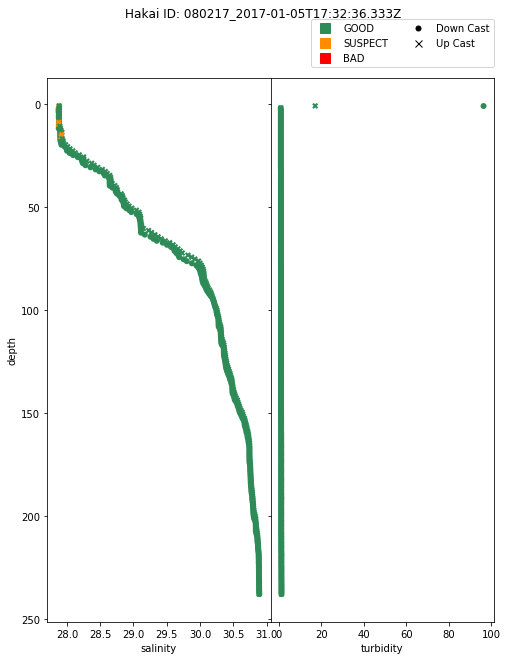

<Figure size 432x288 with 0 Axes>

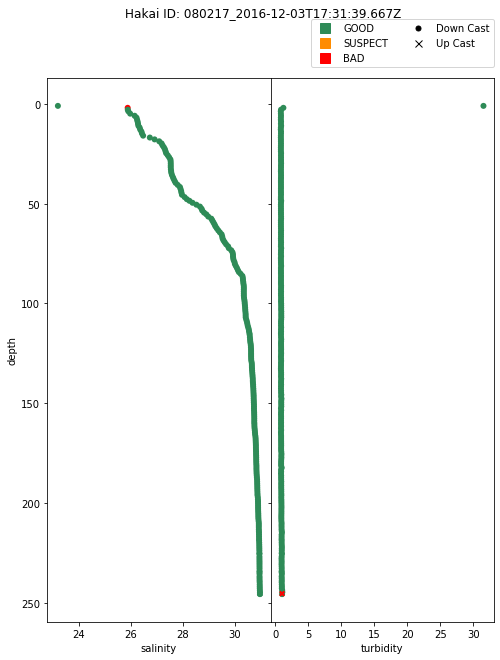

<Figure size 432x288 with 0 Axes>

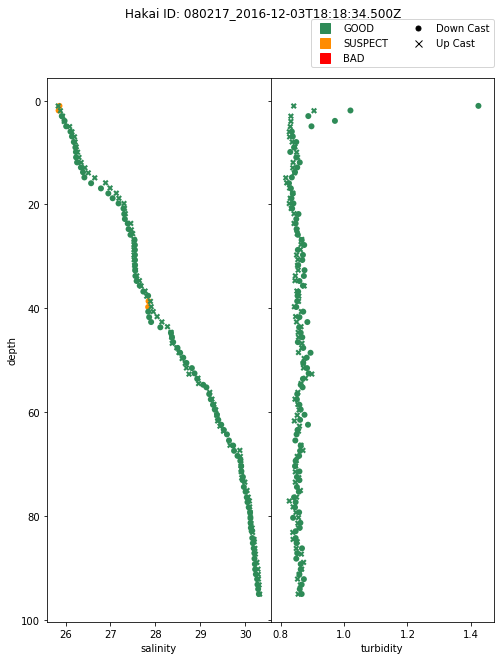

<Figure size 432x288 with 0 Axes>

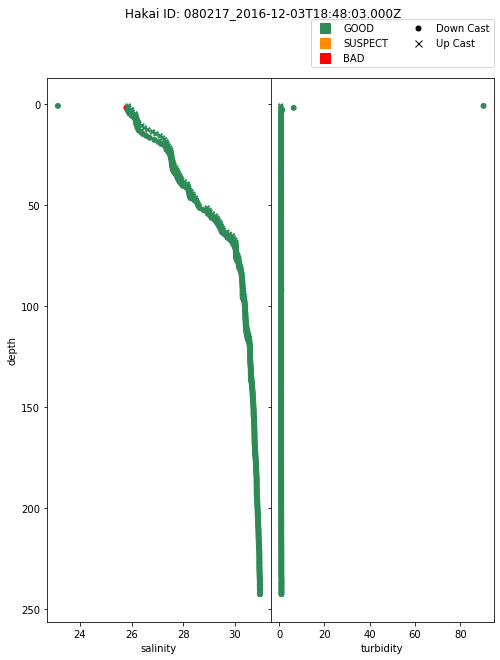

<Figure size 432x288 with 0 Axes>

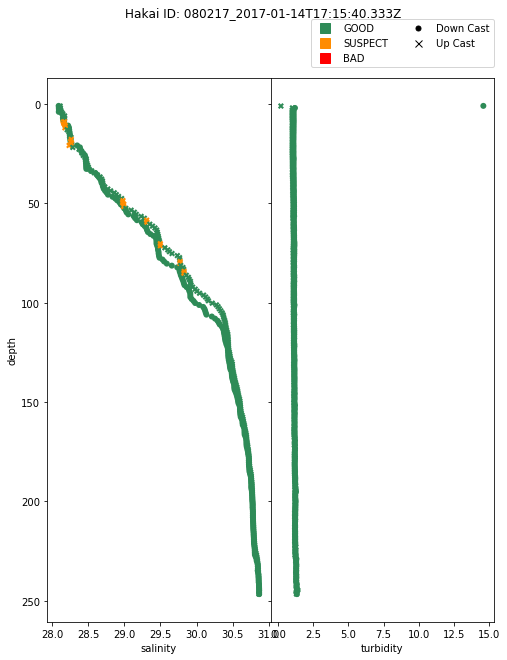

<Figure size 432x288 with 0 Axes>

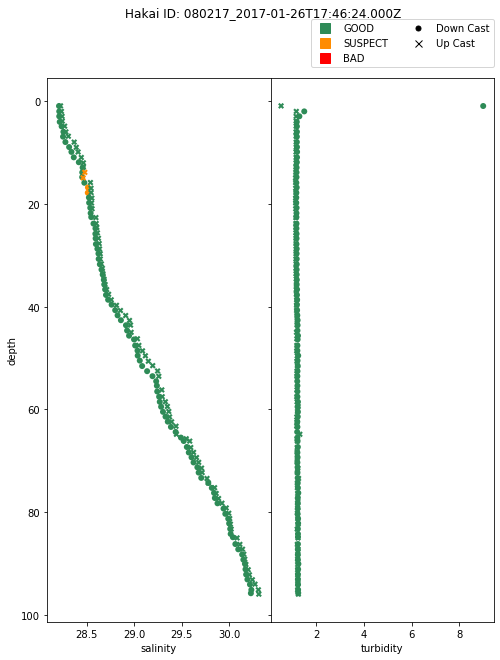

<Figure size 432x288 with 0 Axes>

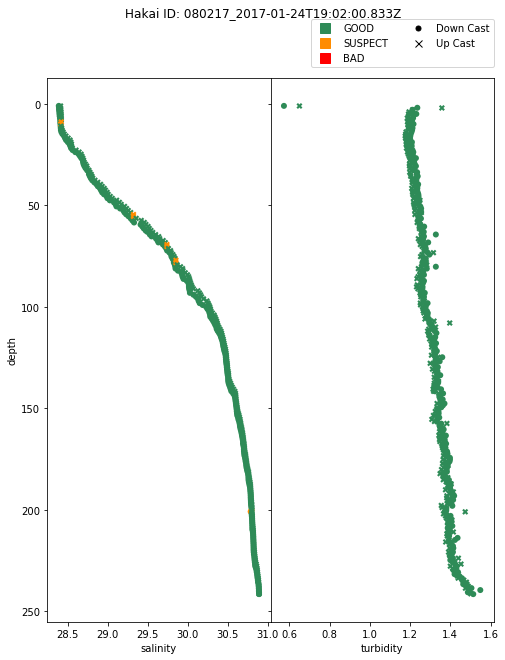

<Figure size 432x288 with 0 Axes>

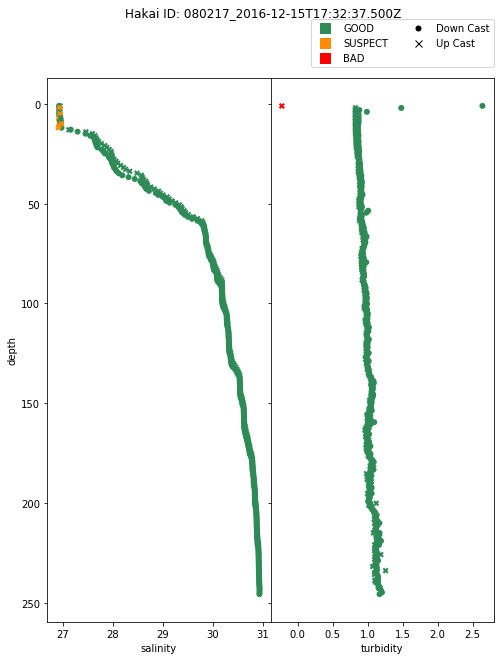

<Figure size 432x288 with 0 Axes>

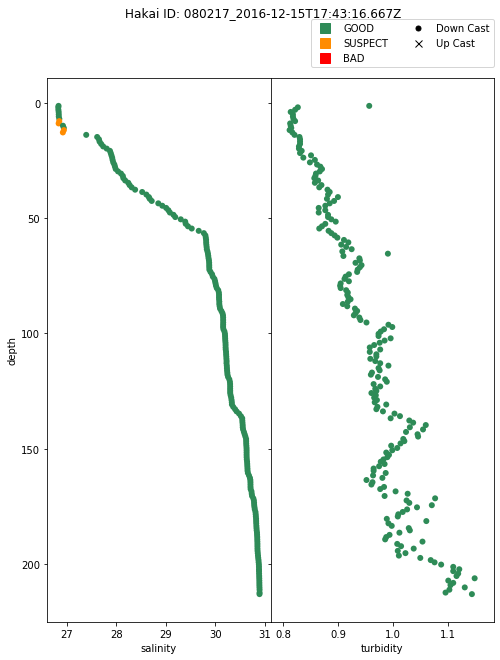

<Figure size 432x288 with 0 Axes>

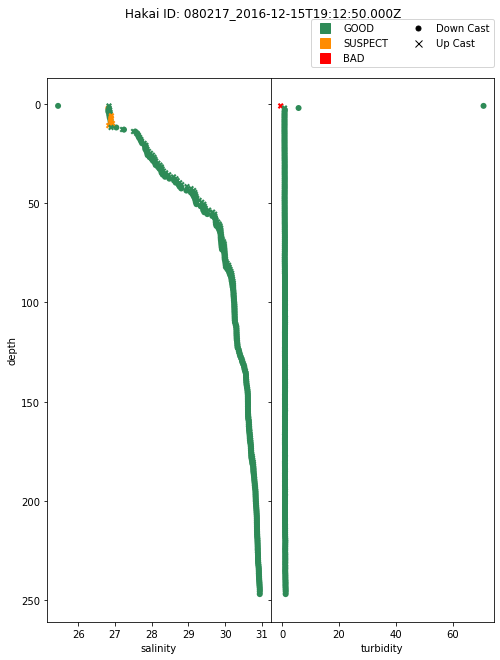

<Figure size 432x288 with 0 Axes>

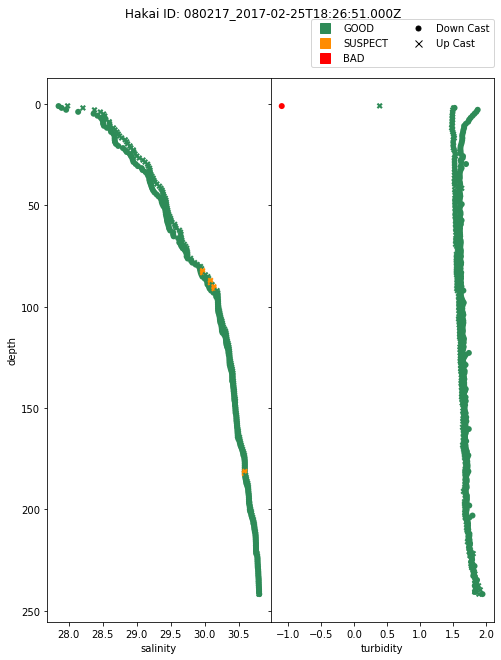

<Figure size 432x288 with 0 Axes>

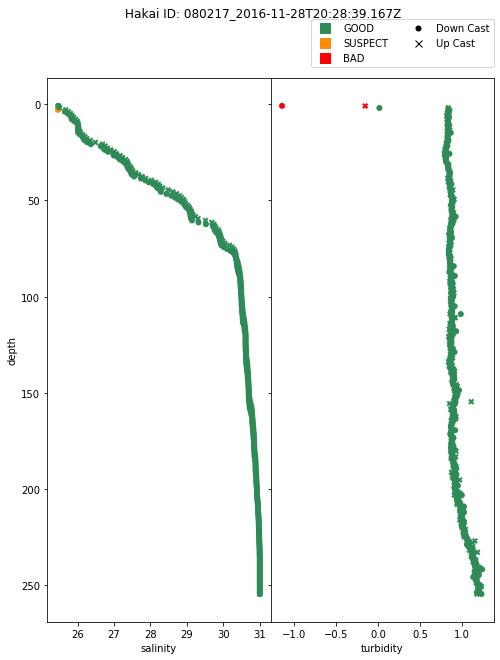

<Figure size 432x288 with 0 Axes>

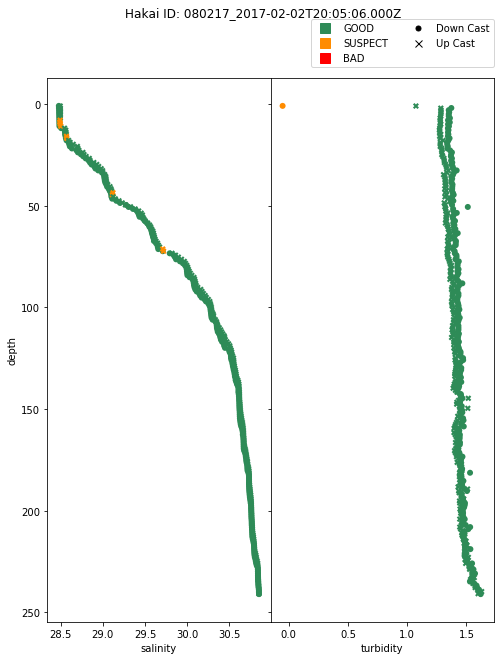

<Figure size 432x288 with 0 Axes>

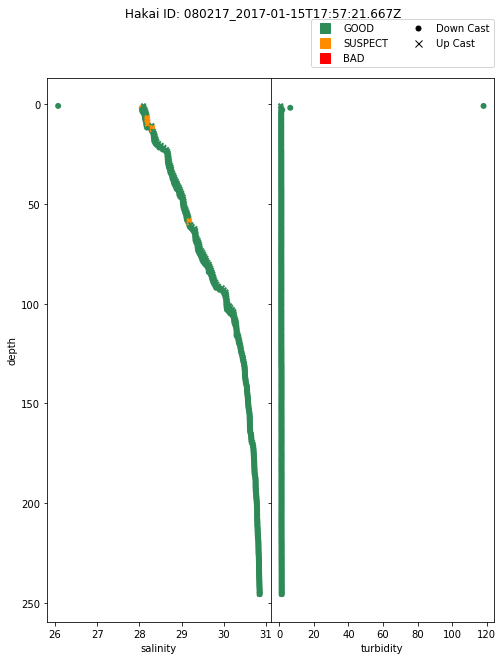

<Figure size 432x288 with 0 Axes>

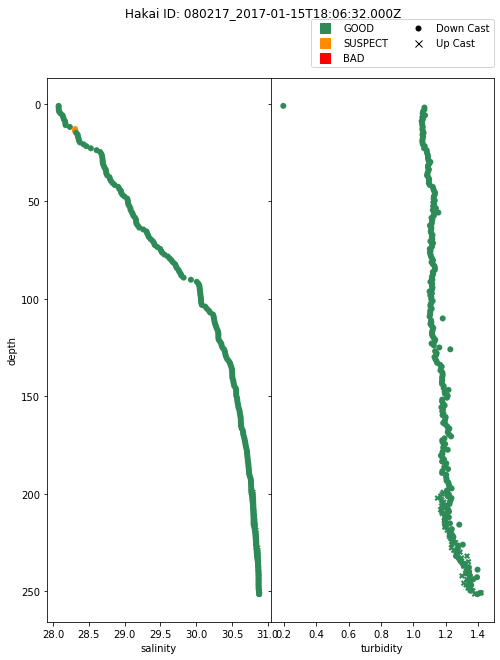

<Figure size 432x288 with 0 Axes>

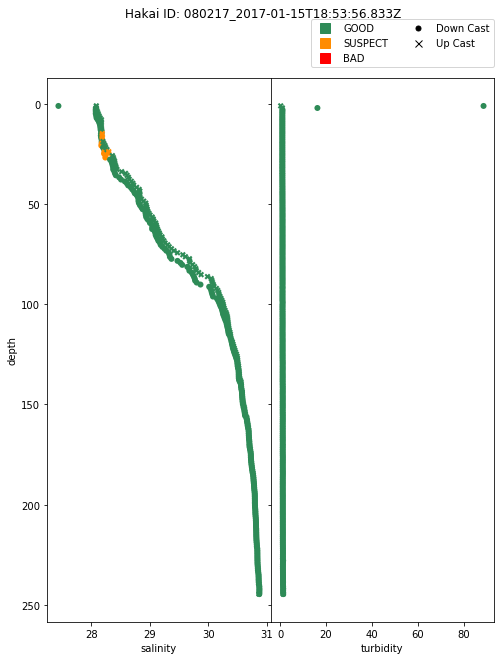

<Figure size 432x288 with 0 Axes>

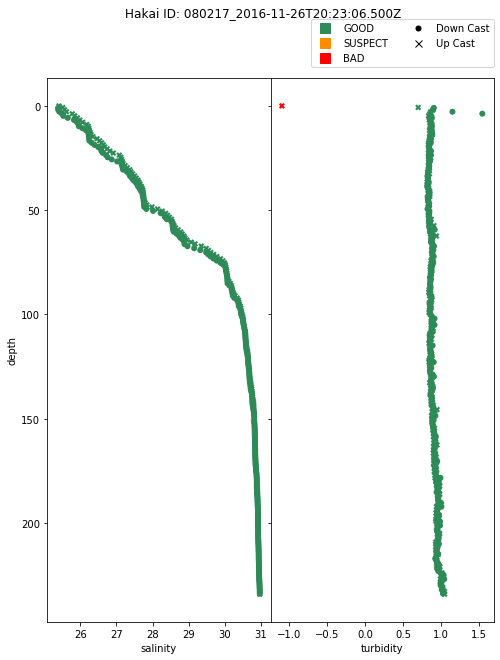

<Figure size 432x288 with 0 Axes>

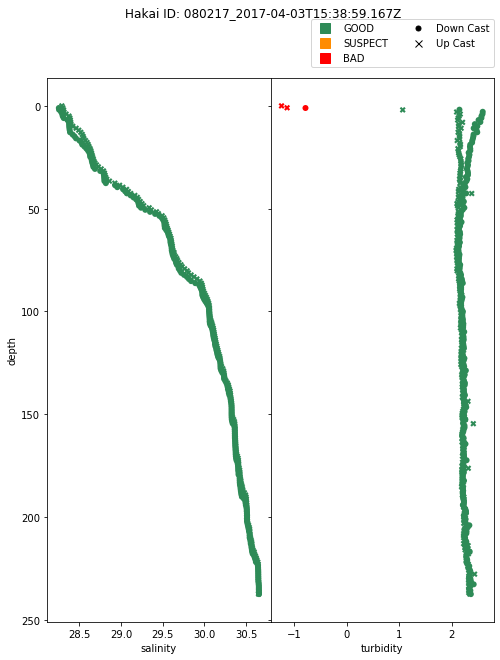

<Figure size 432x288 with 0 Axes>

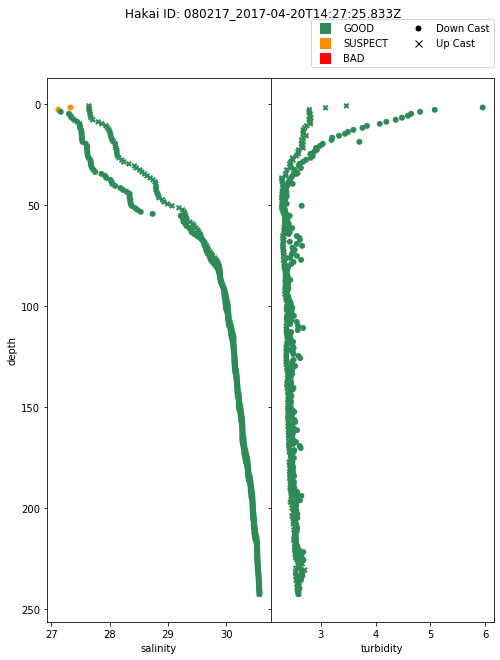

<Figure size 432x288 with 0 Axes>

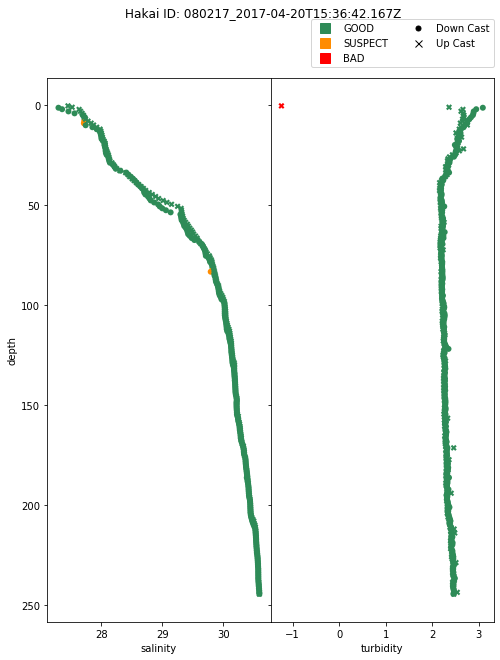

In [20]:
# Now let's plot the flagged data
hakai_qc.get.flag_result_plot(df,variables_to_plot,flagged_hakai_id[:20],flag_type='_qartod_flag')

## Let's review all the profiles one at the time
We'll use plotly do to this.

In [36]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#Define flag colors
qartod_color = {1:'green',2:'yellow',3:'orange',4:'red',9:'purple','1':'green','2':'yellow','3':'orange','4':'red','9':'purple'}

df_hakai_id = df.sort_values(['start_dt','direction_flag','depth']).groupby('hakai_id')
df_iter = iter(df_hakai_id)

A new profile shown everytime you'll run the cell below.

In [40]:
# Iterate one Hakai ID at the time
id,df_temp = next(df_iter)

# Sort them by direction and depth
variables_to_plot = set(qc_config.keys())-{'position','depth','pressure','sigma0'}                    
vars = list(variables_to_plot)
#vars = ['salinity','temperature']

#Create Subplots
fig = make_subplots(rows=1,cols=len(vars), shared_yaxes=True)

kk=1
for var in vars:
    for direction_flag in ['u','d']:
        for flag,color in qartod_color.items():
            df_flag = df_temp[(df_temp[var+'_qartod_flag']==flag) & (df_temp['direction_flag']==direction_flag)].copy()

            if len(df_flag):
                
                if direction_flag is 'u':
                    marker_dict = dict(color=color,line=dict(color='black',width=1))
                else:
                    marker_dict = dict(color=color,line=dict(color='white',width=1))
                    
                fig.add_trace(
                go.Scatter(x=df_flag[var],
                           y=df_flag['depth'],
                           mode='markers',
                           marker=marker_dict,# df_temp[var+'_qartod_flag'],
                           text=df_flag[var+'_flag_description']),
                    row=1,col=kk)
    
    # Add a new line character to x titles every two plots to make x titles more readable
    if (kk % 2)== 0:
        title_x = ' <br>'+var
    else:
        title_x = var
        
    if var in ['par']: # Make PAR x axis log
        fig.update_xaxes(type="log",row=1,col=kk)
        
    fig.update_xaxes(title=title_x, row=1, col=kk)
    kk=kk+1

# Add stuff around each figures
fig.update_yaxes(title_text="Depth (m)",row=1,col=1)
fig.update_yaxes(autorange="reversed",linecolor='black',mirror=True,ticks='outside',showline=True)
fig.update_xaxes(mirror=True,ticks='outside',showline=True,tickangle=45,linecolor='black')
fig.update_layout(height=600, width=1000,showlegend=False)
print(id)
fig.show()

018032_2018-07-16T15:23:14.166Z


In [38]:
# Look at one variable at the time
var = 'salinity'

## Get Figure
fig = px.scatter(df_temp,x=var,y='depth',color=df_temp[var+'_qartod_flag'].astype(int).astype(str),
                 hover_name=var+'_flag_description',color_discrete_map=qartod_color,symbol='direction_flag',opacity=.5)
#fig.update_xaxes(type='log')
fig.update_yaxes(autorange="reversed",linecolor='black',mirror=True,ticks='outside',
                 showline=True,title_text="Depth (m)",)
fig.update_xaxes(mirror=True,ticks='outside',showline=True,tickangle=45,linecolor='black')
fig.update_layout(height=600, width=1000)
fig.show()